In [1]:
#最初のみ(他にも必要なmoduleがあったら"tanaka.yuta.735@eneos.com"に連絡ください)
# !pip install pubchempy
# !pip install rdkit
# !pip install tqdm
# !pip install -U scikit-learn
# !pip install -U combo

In [2]:
import numpy as np
import pickle
import combo
import os
from pandas import Series, DataFrame
import pandas as pd
import csv

from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem, Draw
from rdkit import rdBase, Chem

import pubchempy as pcp
Chem.rdDepictor.SetPreferCoordGen (True)
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## 可視化用
from rdkit.Chem import PandasTools
import matplotlib.pyplot as plt

## 設定パラメータ

In [3]:
############################################
### 　　　　　　探索の設定 　              ###
###                                      ###
###     必要に応じて修正してください        ###
############################################
num_pred      = 50        # 探索で出力したい候補数
max_search    = 0         # 最大の探索:1,最小の探索:0
smiles_column = "smiles"  # smilesのcolmunの名前(学習用データの"training.csv")
obj_column    = "exp_cof" # 目的変数のcolmunの名前(学習用データの"training.csv")
mol_save      = 1         # 分子構造図のexcel出力有無。"有"では時間がかかる。(無：0,有：1)
normalization = 2         # 標準化(探索データ込み):2, 標準化化(学習データのみ):1, 正規化(学習データのみ):0
score         = 'EI'      # PIスコア:'PI', EIスコア:'EI' (EIがおすすめ)

## データの入力

### 学習用データの読み込み

In [4]:
# 学習用データの読み込み
df_comp = pd.read_csv ("./input/training.csv")
cof = df_comp[obj_column]
train_smiles = df_comp["smiles"]
train_num  =  len(df_comp)
print("training用データ数：",train_num)
df_comp

training用データ数： 12


index         names  exp_cof                                      iupac  \
0       1         MB811  0.02278                        2-ethylhexyl oleate   
1       2        ES2958  0.03072                 bis(2-ethylhexyl) azelate    
2       3         KL385  0.07272  neopentyl glycol 3,5,5-trimethylhexanoate   
3       4  Priolube1976  0.02800                         arachidyl stearate   
4       5        MB1381  0.02660                  3,5-diethylnonanyl oleate   
5       6       11MeC23  0.01686                         11-methyltricosane   
6       7        Max3.5  0.02908              9-methyl-11-octylhenicosane     
7       8        Max2.X  0.02938                    11,12-dimethyl docosane   
8       9           DOS  0.02962                 bis(2-ethylhexyl) sebacate   
9      10        ES2911  0.02800                    8-methylnonyl nonanoate   
10     11         M182A  0.01640                              methyl oleate   
11     12           DOP  0.04850                 di(2-ethylhexyl) phthalate   

                                         smiles  
0            CCCCCCCCC=CCCCCCCCC(=O)OCC(CC)CCCC  
1       CCCCC(CC)COC(=O)CCCCCCCC(=O)OCC(CC)CCCC  
2                CC(CC(=O)OCC(C)(C)CO)CC(C)(C)C  
3   CCCCCCCCCCCCCCCCCCCCOC(=O)CCCCCCCCCCCCCCCCC  
4     CCCCCCCCC=CCCCCCCCC(=O)OCC(CC)CC(CC)CCCCC  
5                    CCCCCCCCCCCCC(C)CCCCCCCCCC  
6            CCCCCCCCCCC(CCCCCCCC)CC(C)CCCCCCCC  
7                  CCCCCCCCCCC(C)C(C)CCCCCCCCCC  
8      CCCCC(CC)COC(=O)CCCCCCCCC(=O)OCC(CC)CCCC  
9                    CCCCCCCCC(=O)OCCCCCCCC(C)C  
10                    CCCCCCCCC=CCCCCCCCC(=O)OC  
11  CCCCC(CC)COC(=O)C1=CC=CC=C1C(=O)OCC(CC)CCCC

### TCIデータの読み込み（探索候補）

In [5]:
############################################
### 　　　　TCIデータ読み込み              ###
############################################
df_tci = pd.read_csv ("./input/TCI.csv")
smiles = df_tci["smiles"]
smiles_list = []
for i in range(len(smiles)):
    smiles_list.append(smiles[i])

#### TCIデータ内の中で探索範囲を絞る
1. CとOから構成される分子構造のみを取り出す
2. C数が20~40, O数が10以下, 単体のみを取り出す

In [6]:
# 1. CとOから構成される分子構造のみを取り出す
my_list = smiles_list
characters = ["A","B","Co","Cl","Ca","Cs","Cu","D","E","F","G","H","I","K","M","N","P","R","S","T","U","V","W","X","Y","Z"]
contains_any_character = [any(char in item for char in characters) for item in my_list]

In [7]:
# 2.追加の条件で絞る(C数が20~40, O数が10以下, 単体のみを取り出す)
for i in range(len(contains_any_character)):
    if smiles_list[i].count('C') > 40 :
        contains_any_character[i] = True
    if smiles_list[i].count('C') < 20 :
        contains_any_character[i] = True
    if smiles_list[i].count('O') > 10 :
        contains_any_character[i] = True
    if smiles_list[i].count('.') >= 1 :
        contains_any_character[i] = True

In [8]:
# target list内にtrainingデータのsmilesと探索用のsmilesを格納
target_list = []
target_no_list = []

for i in range(len(train_smiles)):
    target_list.append(train_smiles[i])

for i in range(len(smiles_list)):
    if contains_any_character[i] == False:
        target_list.append(smiles_list[i])      #探索候補として選定された構造
    else:
        target_no_list.append(smiles_list[i])   #選ばれなかった構造
print("探索候補の分子数（学習データ込み）：",len(target_list))

探索候補の分子数（学習データ込み）： 743


#### 探索範囲の分子構造から記述子を作成
1. Rdkit Descriptorに変換
2. 主成分分析で次元圧縮 ("n_components"で次元数を決定)
3. 寄与率の可視化

In [9]:
# 1. RDKIT DESCRIPTORSに変換
target_descriptors = []
for desc in Chem.Descriptors.descList: target_descriptors.append (desc[0]) 
print ("NUMBER OF DESCRIPTORS: ", len (target_descriptors))
descriptor_calculator = MoleculeDescriptors.MolecularDescriptorCalculator (target_descriptors)

# ASSIGN DESCRIPTORS FOR ALL MOLECULES
descriptors = []
target_list_mol = []
i=-1
for s in tqdm (target_list):
    i+=1
    m = Chem.MolFromSmiles (s)
    descriptors.append (descriptor_calculator.CalcDescriptors (m))
    target_list_mol.append(m)

NUMBER OF DESCRIPTORS:  208


  0%|          | 0/743 [00:00<?, ?it/s]

In [10]:
# 2. 主成分分析で次元圧縮 ("n_components"で次元数を決定)学習データ数に合わせて調整してください。
n_components = 3
x = pd.DataFrame (descriptors, columns = target_descriptors).values

# STANDARDIZATION
scaler = StandardScaler ()
xs = scaler.fit_transform (x)
pickle.dump (scaler, open ("./scaler_fitted.pkl", "wb")) 
scaler_df = pd.DataFrame (np.stack ([scaler.mean_, scaler.scale_], -1), columns = ["mean", "std"])
scaler_df.to_csv ("./scaler.csv", index = False)

# PCA
pca = PCA (n_components = n_components)
pca_mat = pca.fit_transform (xs)
pickle.dump (pca, open ("./pca_fitted.pkl", "wb"))  
columns_PC = ["PC{}".format (i + 1) for i in range (n_components)]
pca_df = pd.DataFrame (pca_mat, columns = columns_PC)

# OBJECTIVE VARIABLE
obj = pd.DataFrame (np.stack ([train_smiles, cof], -1), columns = [smiles_column, obj_column])

# MAKE NEW DATAFRAME
pca_df = pd.concat ([obj, pca_df], axis = 1)
print ("SHAPE OF DATAFRAME:       ", pca_df.shape)  

pca_training_df =  pca_df[0:train_num]
pca_search_df =  pca_df[train_num:]
pca_all_df =  pca_df[:]
pca_all_df

SHAPE OF DATAFRAME:        (743, 5)


smiles  exp_cof       PC1  \
0             CCCCCCCCC=CCCCCCCCC(=O)OCC(CC)CCCC  0.02278 -1.156197   
1        CCCCC(CC)COC(=O)CCCCCCCC(=O)OCC(CC)CCCC  0.03072  1.275206   
2                 CC(CC(=O)OCC(C)(C)CO)CC(C)(C)C  0.07272 -1.785601   
3    CCCCCCCCCCCCCCCCCCCCOC(=O)CCCCCCCCCCCCCCCCC    0.028  1.279399   
4      CCCCCCCCC=CCCCCCCCC(=O)OCC(CC)CC(CC)CCCCC   0.0266  0.616461   
..                                           ...      ...       ...   
738                                          NaN      NaN  4.588070   
739                                          NaN      NaN -5.740115   
740                                          NaN      NaN -3.835972   
741                                          NaN      NaN  1.868275   
742                                          NaN      NaN -6.378805   

           PC2       PC3  
0     5.090474  2.174579  
1     4.073115  3.239383  
2    -2.388851 -1.362773  
3    12.977758  6.333394  
4     7.820259  2.642364  
..         ...       ...  
738  -0.200114  0.487021  
739   0.074854 -6.082310  
740   0.916232  0.935386  
741  -2.522819 -0.966995  
742  -4.855562 -2.248298  

[743 rows x 5 columns]

In [11]:
# 主成分化したデータを出力
pca_training_df.to_csv("./training_pca.csv")
pca_search_df.to_csv("./search_pca.csv")
pca_all_df.to_csv("./all_pca.csv")

[0.19811572 0.15678943 0.1213026 ]
累積寄与率； [0.19811572489516857, 0.3549051506115013, 0.4762077506506279]


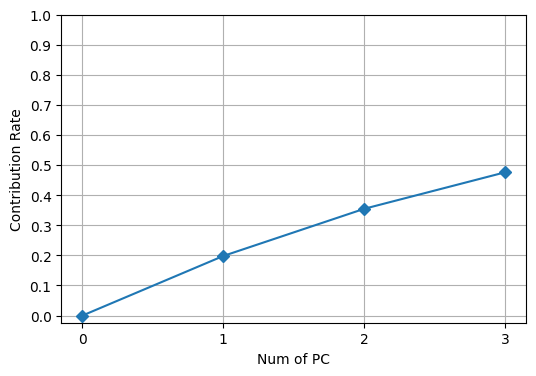

In [12]:
#寄与率
kiyo = pca.explained_variance_ratio_
print(kiyo)
#累積寄与率
kiyo_sum=[0]*len(kiyo)
kiyo_sum[0]=kiyo[0]
for i in range(1,len(kiyo)):
    kiyo_sum[i] = kiyo_sum[i-1] + kiyo[i]
print("累積寄与率；", kiyo_sum)

# 累積寄与率を図示する
cum_con_ratio = np.hstack([0, pca.explained_variance_ratio_]).cumsum()
plt.figure(figsize=(6, 4))
plt.plot(cum_con_ratio, 'D-')
plt.xlabel("Num of PC")
plt.xticks(range(n_components +1))
plt.ylabel("Contribution Rate")
plt.yticks(np.arange(0,1.05,0.1))
plt.grid()
plt.savefig("kiyo.png")
plt.show()

In [13]:
#### 探索候補の分子構造を出力。全てを出力するには非常に時間がかかるため、"output_mol_num"で出力数を変える。
output_mol_num = 50

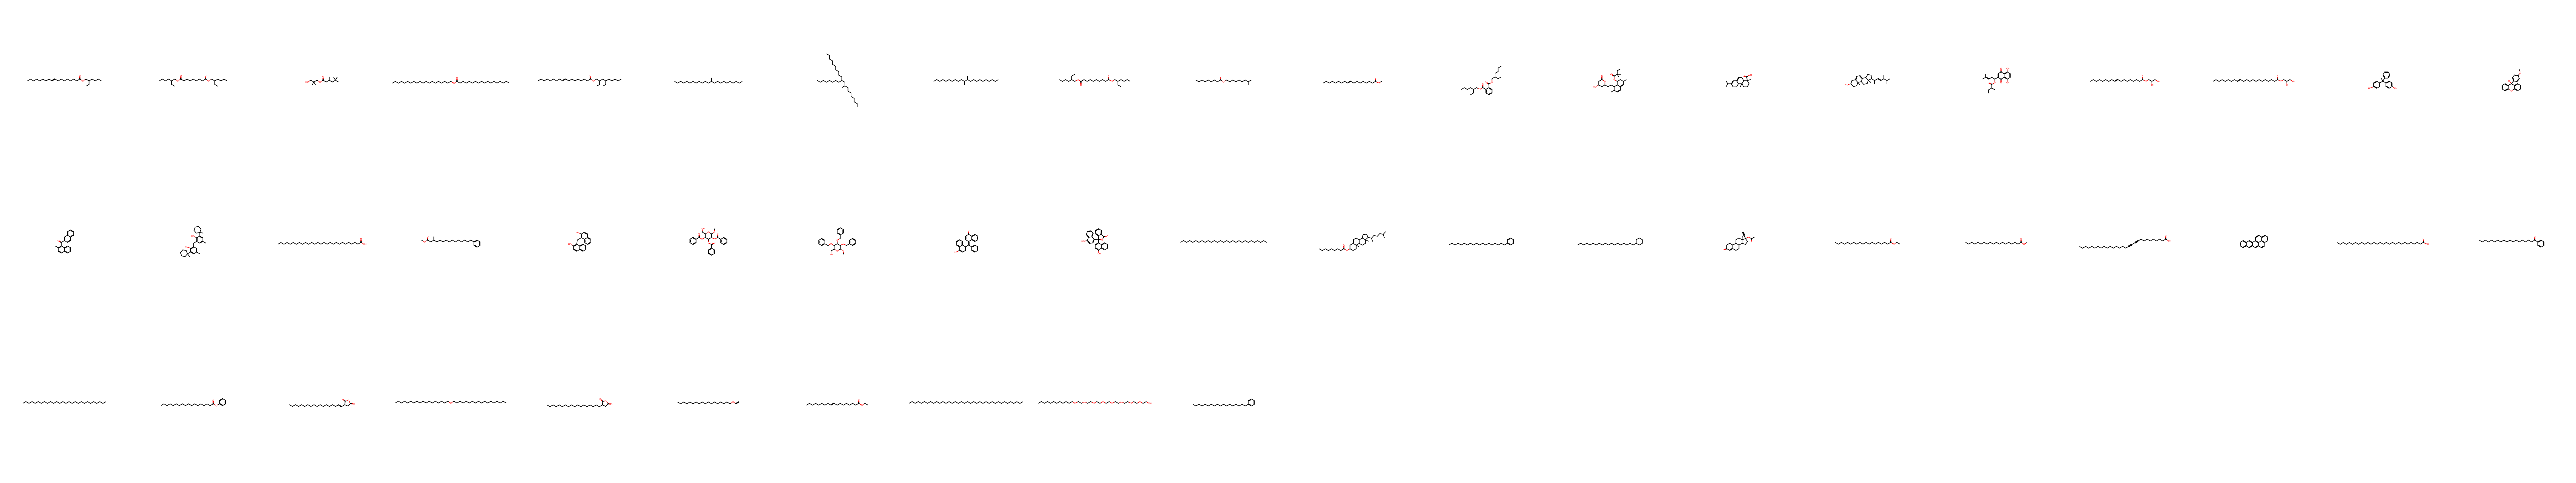

In [14]:
# 全候補分子を可視化
img = Draw.MolsToGridImage(target_list_mol[:output_mol_num],
                           molsPerRow=20, #一列に配置する分子の数
                           subImgSize=(400,500),
                           maxMols = 1000
                           )
# ファイルに出力(候補分子を出力)
name = "traget_molecules"
out_name = name +".png"
with open(out_name, mode='wb') as f:
    f.write(img.data)
img

## ベイズ最適化による探索

### 探索の準備

In [15]:
# 学習用データの読み込み
def load_data():
    Xt = pca_mat
    X = np.asarray(Xt[0:train_num,:])
    te = df_comp[obj_column]
    te = np.asarray(te)
    
    if max_search == 0 :
      te = -1 * te 
    return X, te

In [16]:
# データの読み込み
X, te = load_data()  # 学習データの入力
Xn    = pca_mat      # 探索範囲データを入力

In [17]:
# 学習するためのデータ数を設定
num1=len(X)-1
num2=1

In [18]:
# データの正規化や標準化
XX1 = np.r_[X,Xn]                    # 学習データと探索候補のデータをまとめる
if  normalization == 2:              # 学習データと探索候補のデータを標準化
  mean_X = np.mean(XX1, axis=0)      
  std_X = np.std(XX1, axis=0)        
  XX1n=(XX1-mean_X)/std_X            
elif  normalization == 1:            # 学習データでデータを標準化
  mean_X = np.mean(X, axis=0)        
  std_X = np.std(X, axis=0)        
  XX1n=(XX1-mean_X)/std_X             
elif  normalization == 0:            # 学習データと探索候補のデータを正規化
  x_min = X.min(axis=0, keepdims=True)
  x_max = X.max(axis=0, keepdims=True)
  XX1n = (XX1-x_min)/(x_max-x_min)   

Xc =  XX1n[ 0:(X.shape[0]),:]        # 標準化(もしくは規格化)した学習データを獲得
Xcn  =  XX1n[ (X.shape[0]) :,:]      # 標準化(もしくは規格化)した探索候補データを獲得
print("学習データ数：",len(Xc))
print("探索候補数：",len(Xcn))

学習データ数： 12
探索候補数： 743


In [19]:
# COMBOの学習に用いる(今回は修正の必要なし)
class simulator:
    def __init__( self ):
        _, self.t = load_data()
    
    def __call__( self, action ):
        return self.t[action]

In [20]:
# policyの定義 
policy = combo.search.discrete.policy(test_X=Xc)
# ランダムseedの生成
policy.set_seed( 0 )

In [21]:
# 学習データで学習を実行
print("Start Training")
simulator=simulator()
actions = policy.random_search(max_num_probes=1, num_search_each_probe=num1, simulator=None) #ランダムサーチ
t=simulator(actions)
policy.write(actions,t)
actions = policy.bayes_search(max_num_probes=1, num_search_each_probe=num2, simulator=None, score='TS',
                              interval=0, num_rand_basis=500) #ベイズ探索
t=simulator(actions)
policy.write(actions,t)

Start Training
interactive mode stars ... 
 
0001-th multiple probe search (random) 

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0-th epoch, marginal likelihood -31.70189743549227
50-th epoch, marginal likelihood -32.24319397029284
100-th epoch, marginal likelihood -32.531334903759934
150-th epoch, marginal likelihood -32.68058513390863
200-th epoch, marginal likelihood -32.76214600377794
250-th epoch, marginal likelihood -32.81358523062576
300-th epoch, marginal likelihood -32.85395492582992
350-th epoch, marginal likelihood -32.8924157994712
400-th epoch, marginal likelihood -32.93317015300421
450-th epoch, marginal likelihood -32.978162633458496
500-th epoch, marginal likelihood -33.02843075763045
Done

 Parameters of Gaussian kernel 
 
 width  =  [3.]
 scale  =  1.0
 scale2 =  1.0
 



In [22]:
# 学習の結果を読み込む
predictor = policy.predictor
training  = policy.training
res       = policy.history

In [23]:
# 学習結果を出力(学習ができているかの確認用)
# 低い値の探索では"-"がついている
print ('f(x)=')
print (res.fx[0:res.total_num_search])
res_fx = res.fx[0:res.total_num_search]
best_fx, best_action = res.export_all_sequence_best_fx()
out = np.array([res_fx, best_fx,  best_action]) 
print ('current best')
print (best_fx)
print ("Finish Training")

f(x)=
[-0.02908 -0.0485  -0.0266  -0.0164  -0.07272 -0.02962 -0.03072 -0.02938
 -0.028   -0.028   -0.02278 -0.01686]
current best
[-0.02908 -0.02908 -0.0266  -0.0164  -0.0164  -0.0164  -0.0164  -0.0164
 -0.0164  -0.0164  -0.0164  -0.0164 ]
Finish Training


In [24]:
# 学習結果を保存
res.save('tent.npz')
with open('tent_predictor.dump', 'wb') as f:
        pickle.dump(policy.predictor, f)
policy.training.save('tent_training.npz')
policy.history.save('tent_history.npz')

In [25]:
# データを保存
np.savetxt('tent_Xn.csv',Xn, delimiter='\t',)
np.savetxt('tent_Xc.csv',Xc, delimiter='\t',)
np.savetxt('tent_Xcn.csv', Xcn, delimiter='\t',)

In [26]:
# 一度学習結果を消去
del policy

In [27]:
#################################
#        Bayes探索の開始        #
#################################
# 学習結果の再読み込み
print ("=======Start Bayes Search Part========")
policy = combo.search.discrete.policy(test_X=Xcn)
policy.set_seed( 0 )
policy.load('tent_history.npz', 'tent_training.npz', 'tent_predictor.dump')
training = policy.training
res = policy.history
Xn =  np.loadtxt(fname="tent_Xn.csv", delimiter='\t',)
Xc =  np.loadtxt(fname="tent_Xc.csv", delimiter='\t',)
Xcn = np.loadtxt(fname="tent_Xcn.csv", delimiter='\t',)

=======Start Bayes Search Part========


In [28]:
# Bayes探索開始
print("Start Bayes Search")
actions = policy.bayes_search(max_num_probes=1, num_search_each_probe=num_pred, predictor=predictor, training=training,
                              simulator=None, score=score, interval=1, num_rand_basis=500)

print("actions：", actions)
print("Finish Bayes Search")

Start Bayes Search
Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0-th epoch, marginal likelihood -34.46851561025811
50-th epoch, marginal likelihood -34.51246993342306
100-th epoch, marginal likelihood -34.55248559330741
150-th epoch, marginal likelihood -34.5885987156857
200-th epoch, marginal likelihood -34.62072285135891
250-th epoch, marginal likelihood -34.64884034328413
300-th epoch, marginal likelihood -34.67305131943422
350-th epoch, marginal likelihood -34.693573734262486
400-th epoch, marginal likelihood -34.71073032173698
450-th epoch, marginal likelihood -34.72491930860812
500-th epoch, marginal likelihood -34.73657522590245
Done

 Parameters of Gaussian kernel 
 
 width  =  [0.87653612]
 scale  =  0.01999250032737848
 scale2 =  0.00039970006934022856
 

0003-th multiple probe search (EI) 

actions： [179  66 477 424  55 442 551 208 105  14  31 379 137 236 345 742 481 506
 222 440 633 250 472 216 508 138 150 606 394  89 499 135 

In [29]:
# 出力リストの初期化
rank=[1000]*len(Xcn)
j=-1
for i in actions:
  j=j+1
  rank[i]=j

In [30]:
# 探索候補の平均値と標準偏差を獲得
fmean=policy.predictor.get_post_fmean(policy.training,policy.test)
fcov =policy.predictor.get_post_fcov(policy.training,policy.test)
if max_search == 0 :
    fmean = -1 * fmean    

In [31]:
# EI scoreとPI scoreの獲得
eiscore=combo.search.score.EI(predictor,policy.training,policy.test)
piscore=combo.search.score.PI(predictor,policy.training,policy.test)
fsd=np.sqrt(fcov)

In [32]:
############################################
###           出力のFormat設定           ###
############################################
Xn_all=np.c_[target_list,Xn,fmean,fsd,eiscore,piscore,rank]
df_Xn_all=pd.DataFrame(Xn_all, columns=['smiles']+columns_PC+['mean','sd','eis','pis','rank'])

# csvに結果を保存
df_Xn_all.to_csv('./res_all_summary.csv')

# 分子構造を付けたxlsxを出力。非常に時間がかかるため、出力したくない場合は最初に設定した"mol_save = 0"に。
if mol_save == 1:
    PandasTools.AddMoleculeColumnToFrame(df_Xn_all, molCol='IMAGE', smilesCol='smiles')
    PandasTools.SaveXlsxFromFrame(df_Xn_all, "res_all_summary.xlsx", 
                                  molCol='IMAGE', 
                                  size=(150,100)
                                  )

In [33]:
# 出力リストの初期化
Xn_ac=[0]*len(actions)
fmean_ac=[0]*len(actions)
fsd_ac=[0]*len(actions)
eiscore_ac=[0]*len(actions)
piscore_ac=[0]*len(actions)
target_list_ac=[0]*len(actions)

In [34]:
# 出力の準備
for i in range(len(actions)):
   Xn_ac[i]=Xn[actions[i]]
   fmean_ac[i]=fmean[actions[i]]
   fsd_ac[i]=fsd[actions[i]]
   eiscore_ac[i]=eiscore[actions[i]]
   piscore_ac[i]=piscore[actions[i]]
   target_list_ac[i]=target_list[actions[i]]
Xn_out=np.c_[target_list_ac,Xn_ac,fmean_ac,fsd_ac,eiscore_ac,piscore_ac]
df_Xn_out=pd.DataFrame(Xn_out, columns=['smiles']+columns_PC+['mean','sd','eis','pis'])
df_Xn_out.to_csv('./res_summary.csv')

# 分子構造を付けたxlsxを出力。非常に時間がかかるため、出力したくない場合は最初に設定した"mol_save = 0"に。
if mol_save == 1:
    PandasTools.AddMoleculeColumnToFrame(df_Xn_out, molCol='IMAGE', smilesCol='smiles')
    PandasTools.SaveXlsxFromFrame(df_Xn_out, "res_summary.xlsx", 
                                  molCol='IMAGE', 
                                  size=(150,100)
                                  )

In [35]:
# 出力(標準出力)
print("actions")
print (len(actions))
for i in range(len(actions)):
   print ("---- Rank =",i,"----")
   print ("res_component:",Xn[actions[i]])
   print ("res_mean:",fmean[actions[i]])
   print ("res_std:",fsd[actions[i]])
   print (target_list[actions[i]])

actions
50
---- Rank = 0 ----
res_component: [-8.85036685  5.25931712  0.68131856]
res_mean: 0.01684196693572699
res_std: 0.011130330756221083
CCCCCCCCCCCCCC=CCCCCCCCC
---- Rank = 1 ----
res_component: [-8.49083165  7.16060486  1.52145372]
res_mean: 0.01899357250202878
res_std: 0.011434056313247733
CCCCCCCCCCCCCCCCCCCCCCCCC
---- Rank = 2 ----
res_component: [-4.23819924 -0.1453507   0.97398666]
res_mean: 0.02123314182428572
res_std: 0.011885101459241581
CCC=CCC=CCC=CCC=CCC=CCCCC(=O)O
---- Rank = 3 ----
res_component: [-5.8322508   5.89751405  2.30348978]
res_mean: 0.025314868779750227
res_std: 0.014928414305373441
CCCCCCCCCCCCOCCCCCCCCCCCC
---- Rank = 4 ----
res_component: [-3.37363475  2.71155304  2.71932572]
res_mean: 0.025101877834174103
res_std: 0.014105822172786409
CCCCCCCCCCCCCCCCCCC1=C(C=CC(=C1)OC)OC
---- Rank = 5 ----
res_component: [3.2622028  6.99932374 3.28426653]
res_mean: 0.026194417496109942
res_std: 0.01416369206268846
CCCCCCCCCCCCCCCCCCOC(=O)CCC1=CC(=C(C(=C1)C(C)(C)C)O)

### Bayseお勧め順(actions)、スコア順（PI,EI）、目的変数順(mean)にソート

In [36]:
# 出力する分子数の個数
output_num = 20

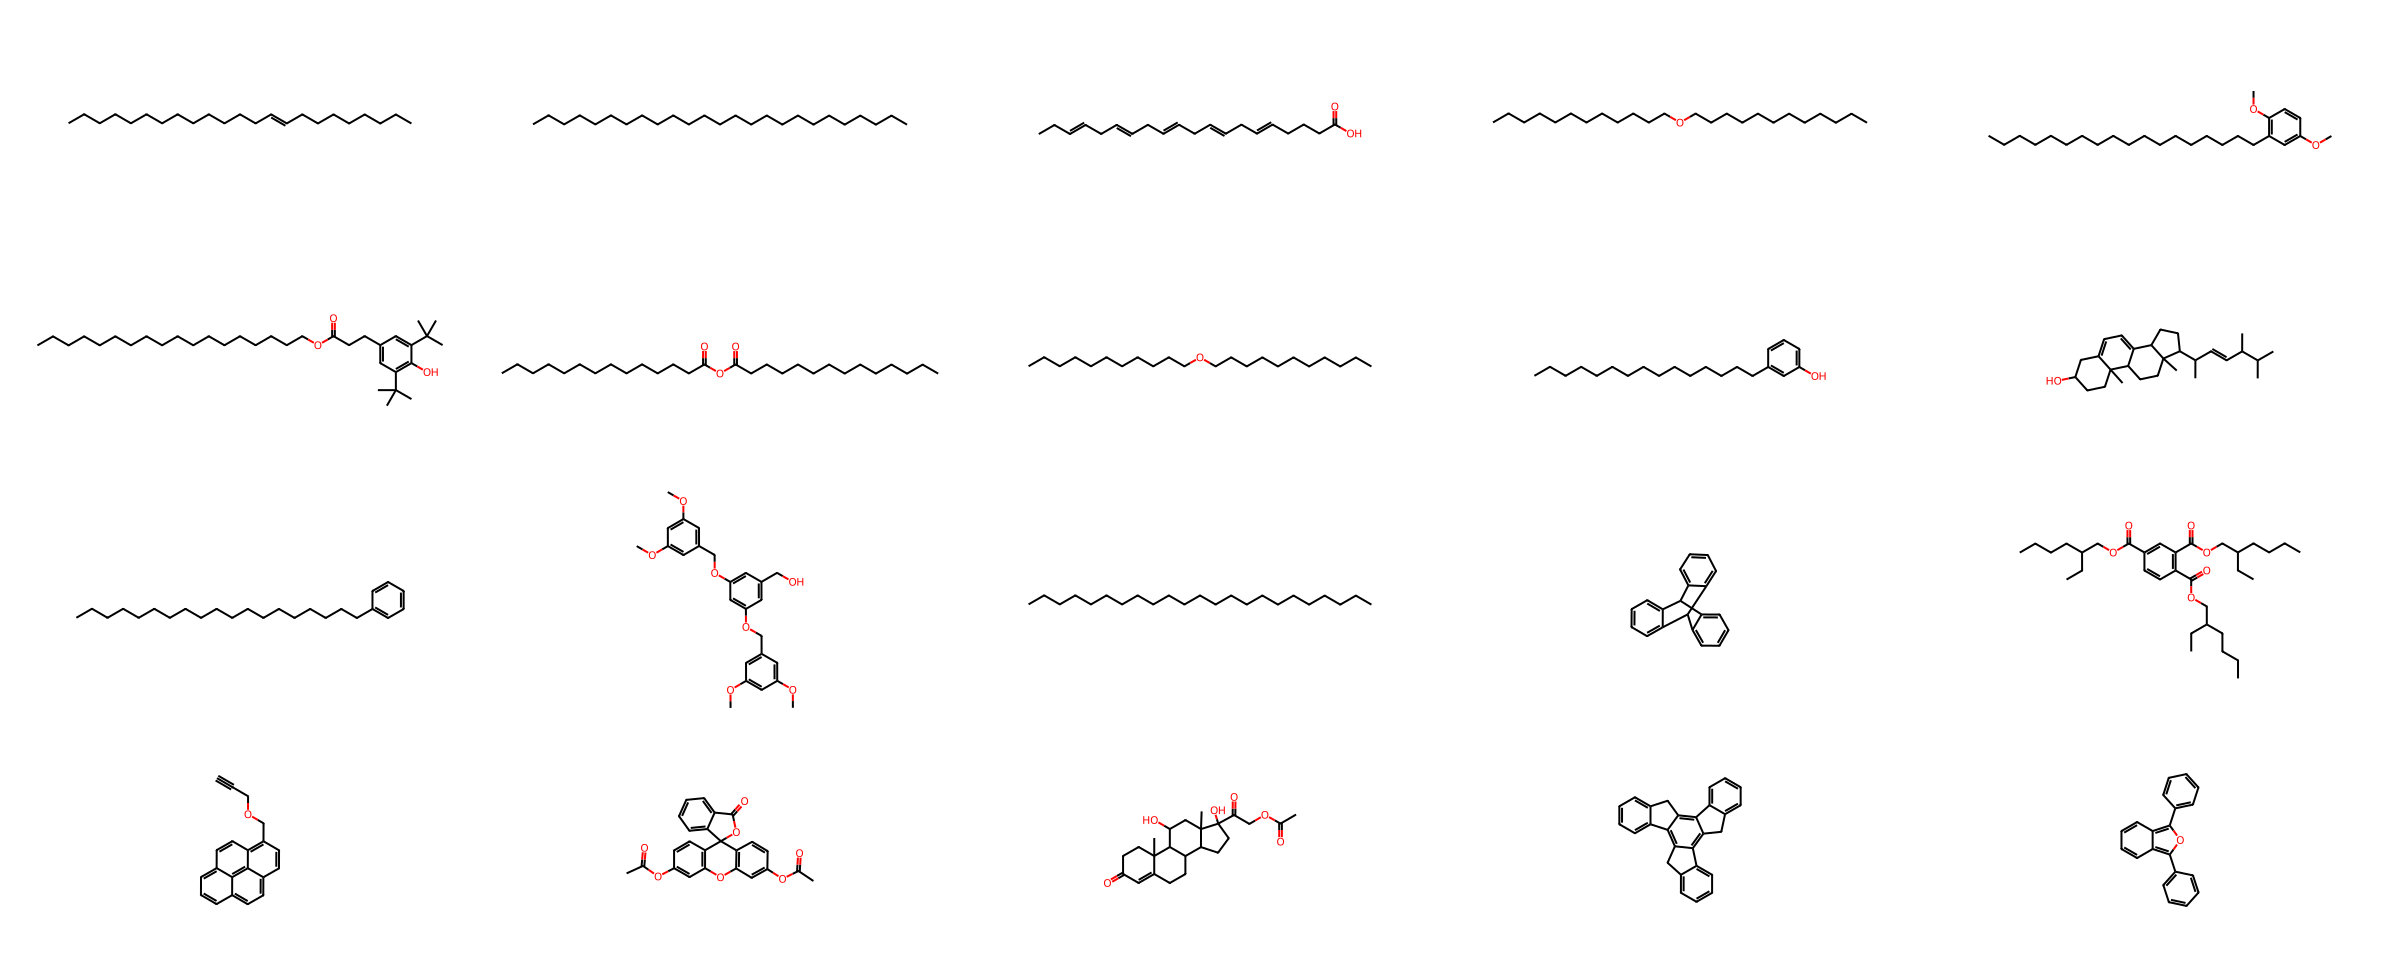

In [37]:
## actions順データをmolに変換
new_target_mols = []
for i in range(len(actions)) :
        tent_mol = Chem.MolFromSmiles(target_list[actions[i]])
        new_target_mols.append(tent_mol)

# 全候補分子を可視化
img = Draw.MolsToGridImage(new_target_mols[0:output_num],
                           molsPerRow=5, #一列に配置する分子の数
                           subImgSize=(480,240),
                           maxMols = 1000
                           )

# ファイルに出力
out_name = "actions_sort_mol.png"
with open(out_name, mode='wb') as f:
    f.write(img.data)
img

In [38]:
## それぞれでsortを行う
Xn_index = []
for i in range(len(Xn_all)):
    Xn_index.append(i)
df_Xn_index = pd.DataFrame(Xn_index,columns=["num"]) 
Xn_all_index = pd.concat([df_Xn_all, df_Xn_index], axis=1)

# meanでsort
df_Xn = Xn_all_index.sort_values('mean', ascending=True)
mean_list = []
for i in range(output_num):
    mean_list.append(df_Xn.iloc[i]['num'])
    
# EIスコアでsort
Xn_all_index.loc[:,'eis'] = Xn_all_index.loc[:,'eis'].astype(float)* 100000   # 指数ではsortがバグるため
df_Xn = Xn_all_index.sort_values('eis', ascending=False)
EI_list = []
for i in range(output_num):
    EI_list.append(df_Xn.iloc[i]['num'])
    
# PIスコアでsort
Xn_all_index.loc[:,'pis'] = Xn_all_index.loc[:,'pis'].astype(float)* 100000   # 指数ではsortがバグるため
df_Xn = Xn_all_index.sort_values('pis', ascending=False)
PI_list = []
for i in range(output_num):
    PI_list.append(df_Xn.iloc[i]['num'])

#### 目的変数の期待値順でsort

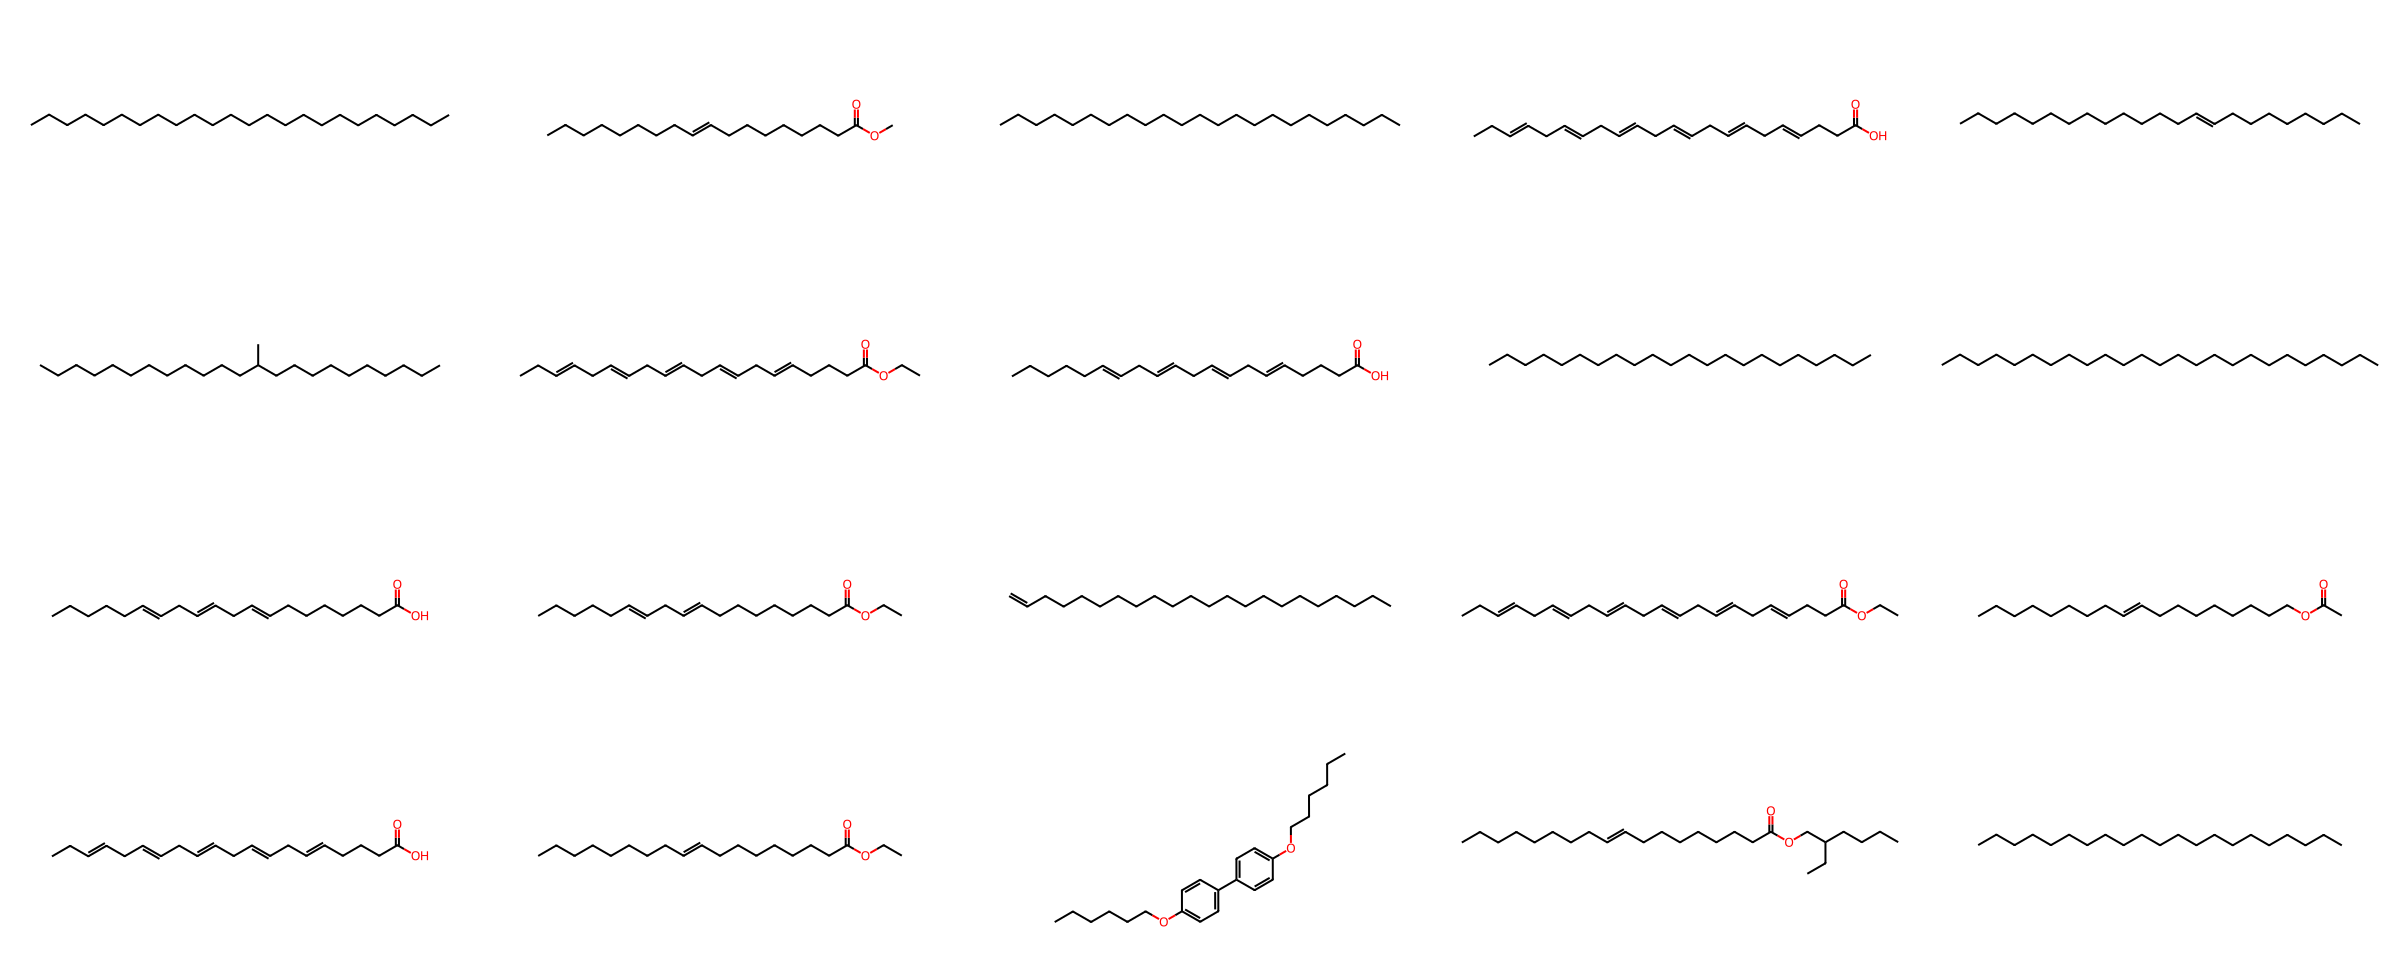

In [39]:
# molに変換
mean_mols = []
for i in range(len(mean_list)) :
        tent_mol = Chem.MolFromSmiles(df_Xn_all['smiles'][mean_list[i]])
        mean_mols.append(tent_mol)

img = Draw.MolsToGridImage(mean_mols[0:output_num],
                           molsPerRow=5, #一列に配置する分子の数
                           subImgSize=(480,240),
                           maxMols = 1000
                           )
# ファイルに出力
out_name = "mean_sort_mol.png"
with open(out_name, mode='wb') as f:
    f.write(img.data)

img

#### eiスコアでsort

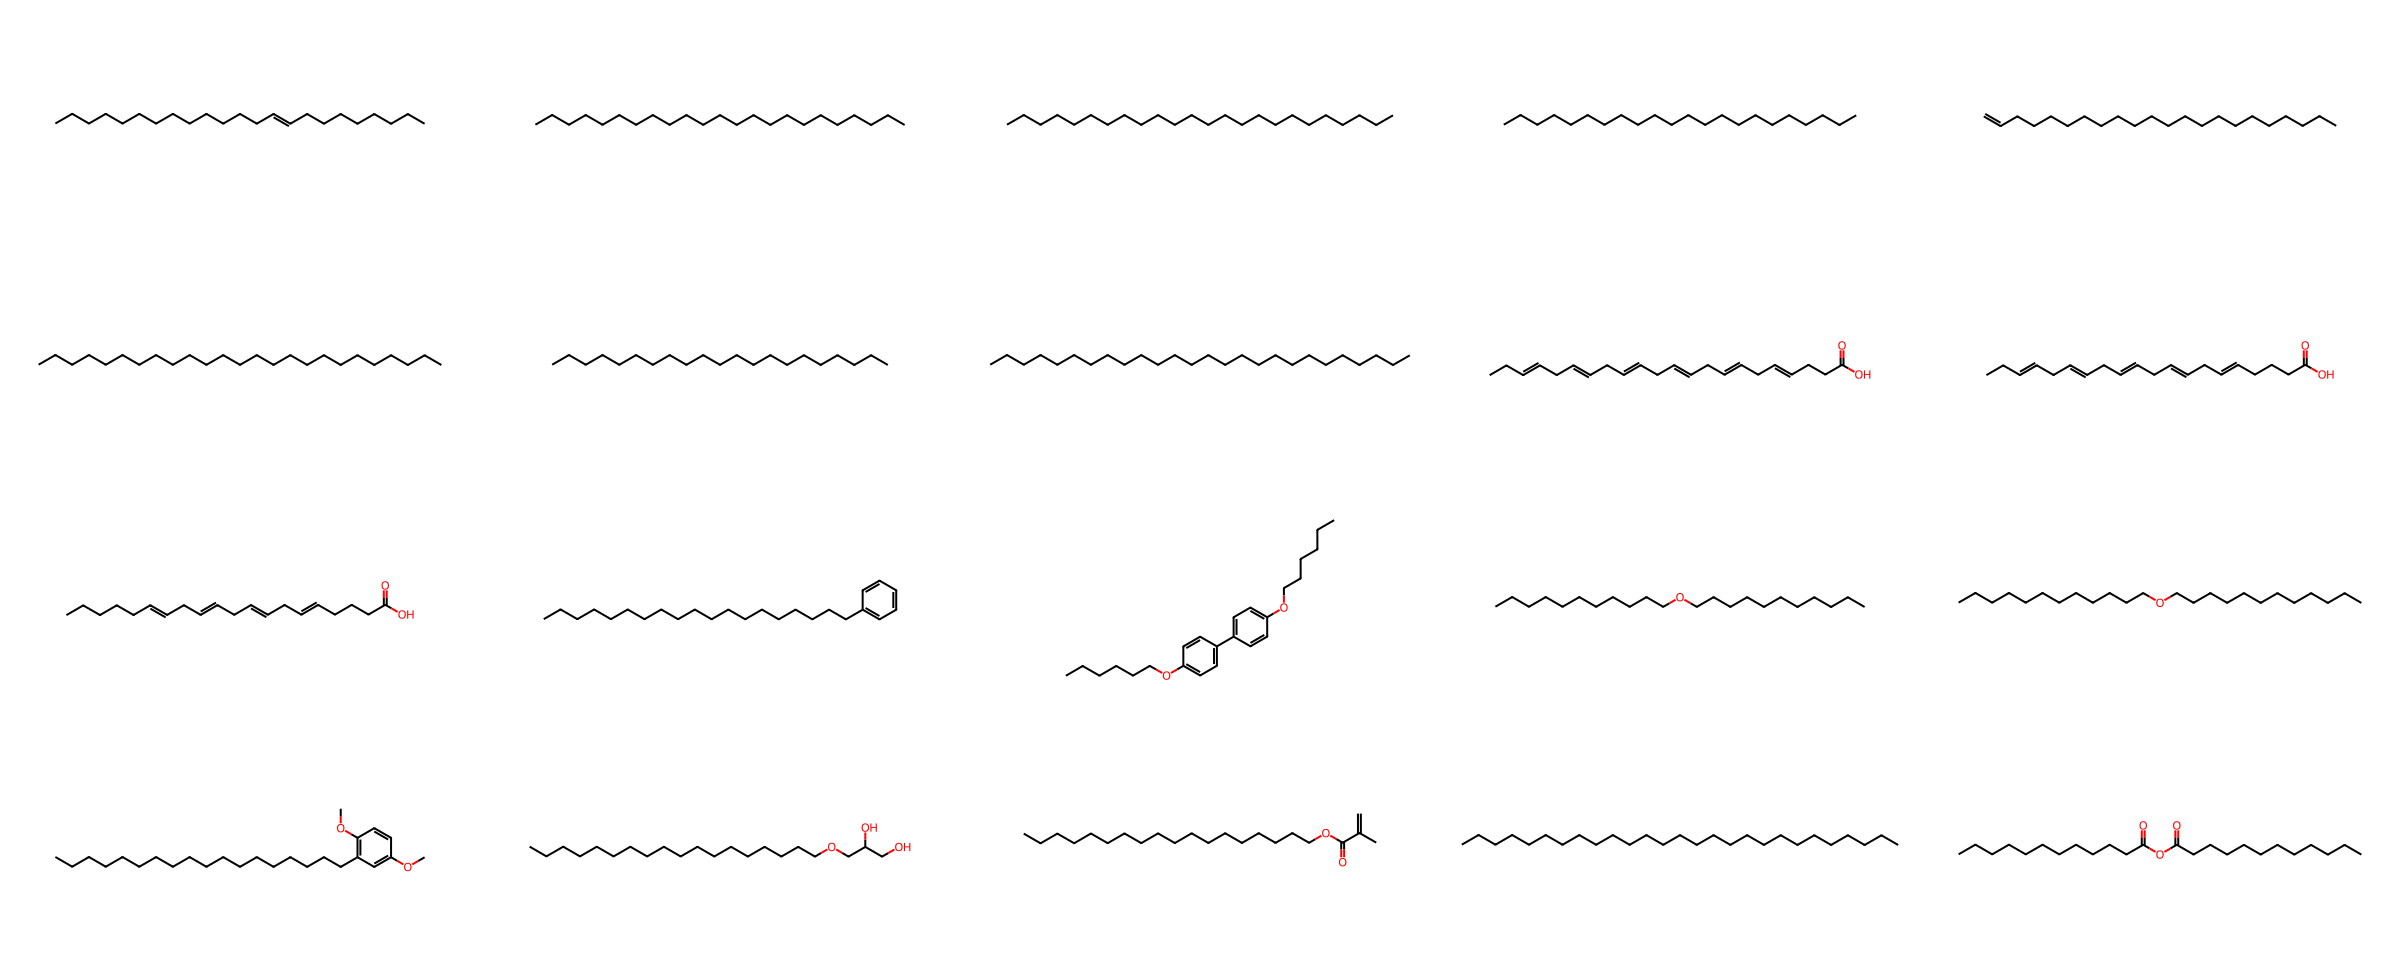

In [40]:
# molに変換
EI_mols = []
for i in range(len(EI_list)) :
        tent_mol = Chem.MolFromSmiles(df_Xn_all['smiles'][EI_list[i]])
        EI_mols.append(tent_mol)

# 分子を可視化
img = Draw.MolsToGridImage(EI_mols[0:output_num],
                           molsPerRow=5, #一列に配置する分子の数
                           subImgSize=(480,240),
                           maxMols = 1000
                           )

# ファイルに出力
out_name = "EI_sort_mol.png"
with open(out_name, mode='wb') as f:
    f.write(img.data)

img

#### piスコアでsort

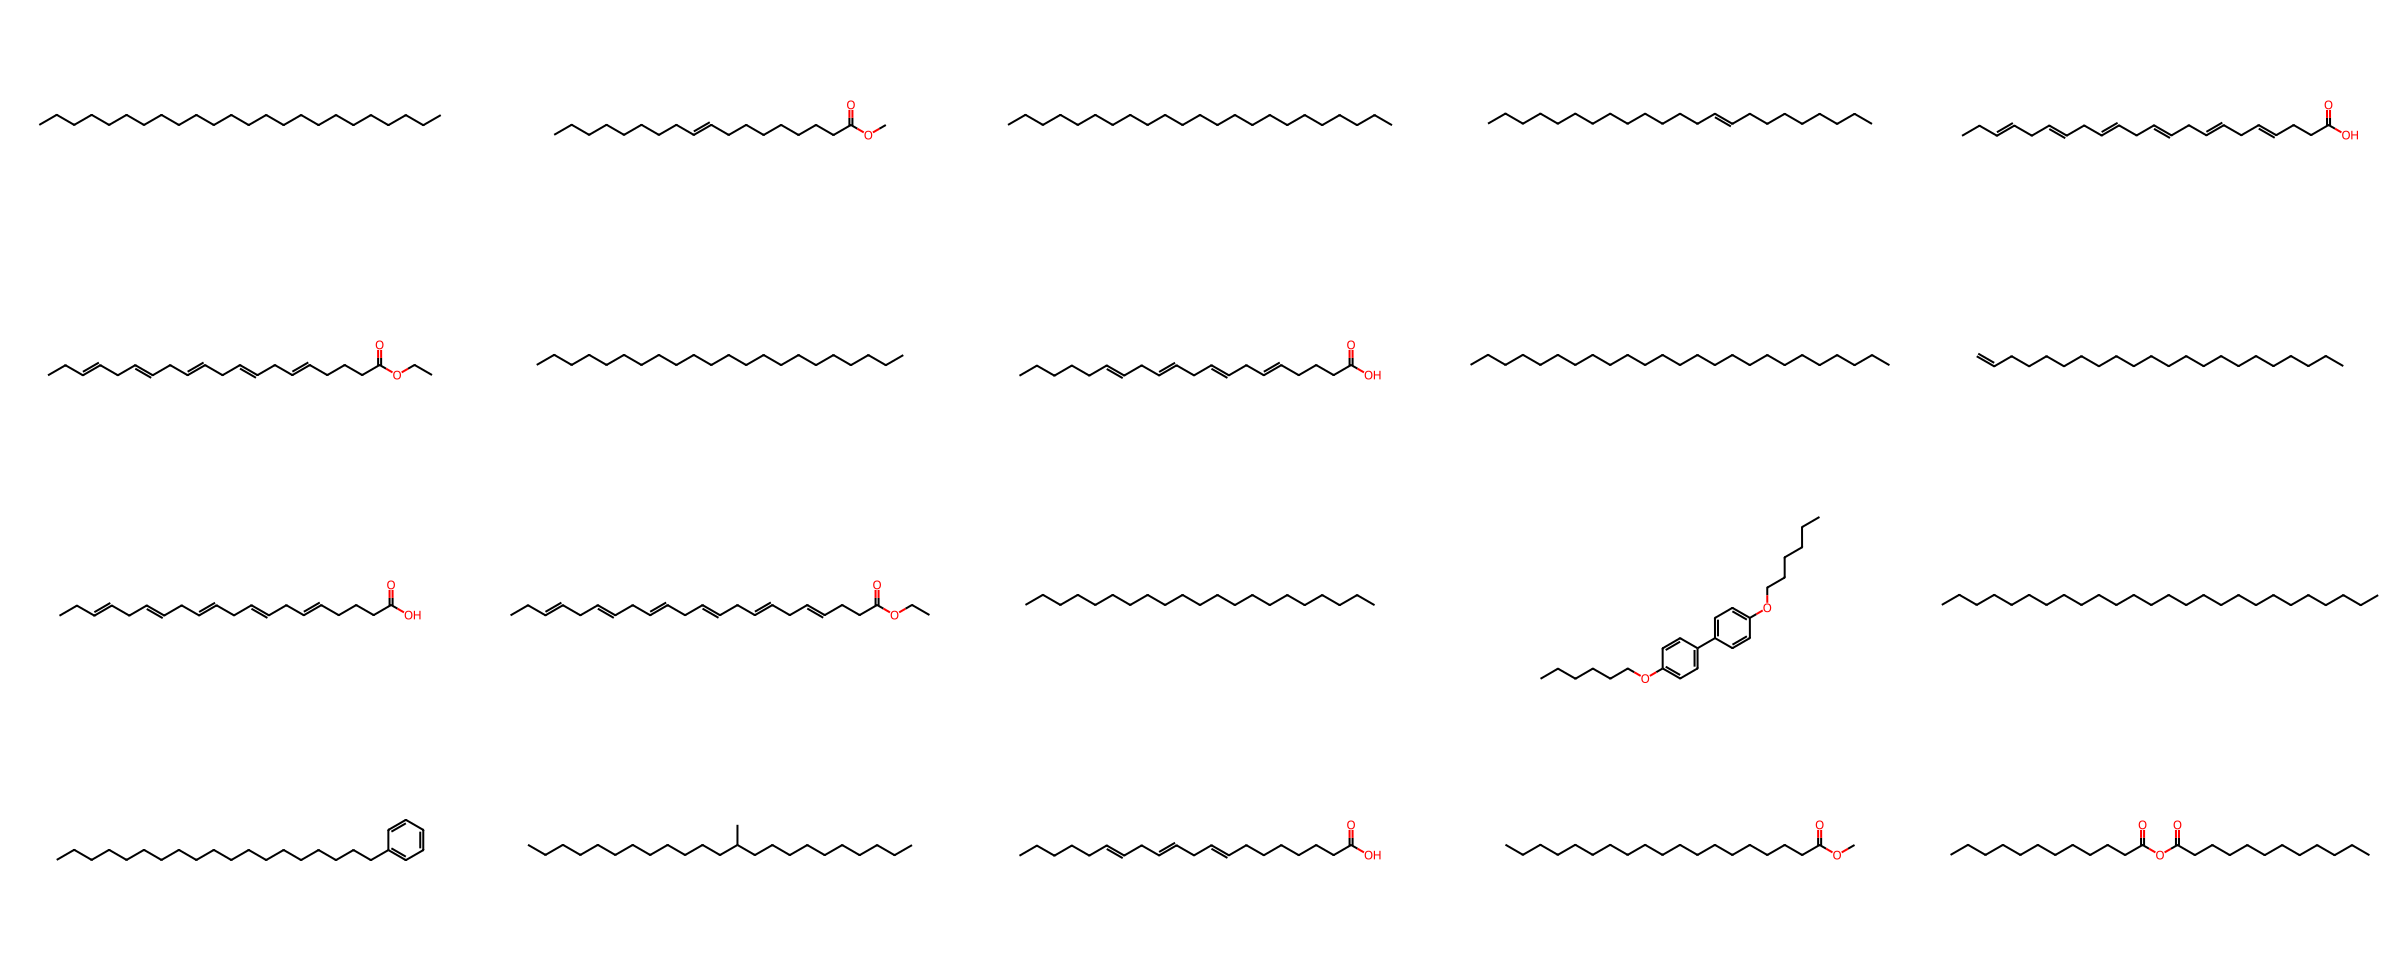

In [41]:
# molに変換
PI_mols = []
for i in range(len(EI_list)) :
        tent_mol = Chem.MolFromSmiles(df_Xn_all['smiles'][PI_list[i]])
        PI_mols.append(tent_mol)

# 分子を可視化
img = Draw.MolsToGridImage(PI_mols[0:output_num],
                           molsPerRow=5, #一列に配置する分子の数
                           subImgSize=(480,240),
                           maxMols = 1000
                           )

# ファイルに出力
out_name = "PI_sort_mol.png"
with open(out_name, mode='wb') as f:
    f.write(img.data)

img